In [1]:
import nltk
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Imports - our files
import utils
import models

# Global definitions - data
DATA_FN = 'data/crowdflower_data.csv'
LABEL_NAMES = ["happiness", "worry", "neutral", "sadness"]

# Global definitions - architecture
EMBEDDING_DIM = 100  # We will use pretrained 100-dimensional GloVe
BATCH_SIZE = 128
NUM_CLASSES = 4
USE_CUDA = torch.cuda.is_available()  # CUDA will be available if you are using the GPU image for this homework

# Global definitions - saving and loading data
FRESH_START = False  # set this to false after running once with True to just load your preprocessed data from file
#                     (good for debugging)
TEMP_FILE = "temporary_data.pkl"  # if you set FRESH_START to false, the program will look here for your data, etc.

In [2]:
# load the data and embeddings from file
try:
    with open(TEMP_FILE, "rb") as f:
        print("Loading DataLoaders and embeddings from file....")
        train_generator, dev_generator, test_generator, embeddings, train_data = pickle.load(f)
except FileNotFoundError:
    raise FileNotFoundError("You need to have saved your data with FRESH_START=True once in order to load it!")

Loading DataLoaders and embeddings from file....


In [50]:
# this one works for just training
class RNNModel_training(nn.Module):
    def __init__(self, sentence_len, output_dim,hidden_dim, weight):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        self.sentence_len = sentence_len
        self.embed_dim = weight.size(1)       
        # Define embeddings
        self.embedding = nn.Embedding.from_pretrained(weight)
        # RNN
        self.rnn = nn.RNN(self.embed_dim,hidden_dim,num_layers=2,batch_first=True)     
        #self.drop_layer = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def get_len(self, x):
        x_len = []
        for ix in x:
            if ix[-1] != 0:
                x_len.append(len(ix))
            else:
                x_len.append((ix==0).nonzero()[0])           
        return x_len
    
    def forward(self, x):
        batch_size = x.size(0)
        x_lengths = self.get_len(x)
        x = self.embedding(x).float()
        out, _ = self.rnn(x)
        #print(np.shape(out))
        selected = torch.zeros(batch_size, self.hidden_dim, dtype=torch.float)
        for i, l in enumerate(x_lengths):
            selected[i,:] = out[i,l-1,:]
        #print(np.shape(selected))
        return self.fc(selected)

In [52]:
class RNNModel(nn.Module):
    def __init__(self, sentence_len, output_dim,hidden_dim, weight):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        self.sentence_len = sentence_len
        self.embed_dim = weight.size(1)       
        # Define embeddings
        self.embedding = nn.Embedding.from_pretrained(weight)
        # RNN
        self.rnn = nn.RNN(self.embed_dim,hidden_dim,num_layers=2,batch_first=True)     
        #self.drop_layer = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def get_len(self, x):
        x_len = []
        for ix in x:
            if ix[-1] != 0:
                x_len.append(len(ix))
            else:
                x_len.append((ix==0).nonzero()[0])           
        return x_len
    
    def pad(self, x):
        if x.size(1) > self.sentence_len:
            return x[:,:self.sentence_len]
        elif x.size(1) < self.sentence_len:
            tmp = torch.zeros(x.size(0), self.sentence_len-x.size(1), dtype=torch.long)
            return torch.cat((x,tmp), 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        x_lengths = self.get_len(x)
        if x.size(1) != self.sentence_len:
            x = self.pad(x)
        x = self.embedding(x).float()
        out, _ = self.rnn(x)
        #print(np.shape(out))
        selected = torch.zeros(batch_size, self.hidden_dim, dtype=torch.float)
        for i, l in enumerate(x_lengths):
            selected[i,:] = out[i,l-1,:]
        #print(np.shape(selected))
        return self.fc(selected)

In [53]:
HIDDEN_DIM = 64
SENTENCE_LEN = 91
model3 = RNNModel(SENTENCE_LEN, NUM_CLASSES, HIDDEN_DIM, embeddings)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters())
  
EPOCHS = 20
losses = []
for iepoch in range(EPOCHS): 
    i = 0
    for train_batch, train_label in train_generator:
#         if i>10:
#             break
#         i += 1
        # Compute and print loss
        loss = criterion(model3(train_batch),train_label)
        #print(loss.item()) 

        # Zero the gradients
        model3.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()
    #print(loss.item()) 
    total_loss = 0
    for ibatch, ilabel in dev_generator:
        dev_loss = criterion(model3(ibatch), ilabel)
        total_loss += dev_loss
    print(iepoch, total_loss)
    losses.append(total_loss)

0 tensor(26.5086, grad_fn=<AddBackward0>)
1 tensor(25.7874, grad_fn=<AddBackward0>)
2 tensor(25.3442, grad_fn=<AddBackward0>)
3 tensor(25.5543, grad_fn=<AddBackward0>)
4 tensor(25.3593, grad_fn=<AddBackward0>)
5 tensor(25.3282, grad_fn=<AddBackward0>)
6 tensor(25.3982, grad_fn=<AddBackward0>)
7 tensor(25.3486, grad_fn=<AddBackward0>)
8 tensor(25.4165, grad_fn=<AddBackward0>)
9 tensor(25.4576, grad_fn=<AddBackward0>)
10 tensor(25.7182, grad_fn=<AddBackward0>)
11 tensor(25.5914, grad_fn=<AddBackward0>)
12 tensor(26.5881, grad_fn=<AddBackward0>)
13 tensor(25.7568, grad_fn=<AddBackward0>)
14 tensor(25.7759, grad_fn=<AddBackward0>)
15 tensor(25.7505, grad_fn=<AddBackward0>)
16 tensor(25.6915, grad_fn=<AddBackward0>)
17 tensor(26.0194, grad_fn=<AddBackward0>)
18 tensor(25.7799, grad_fn=<AddBackward0>)
19 tensor(25.9161, grad_fn=<AddBackward0>)


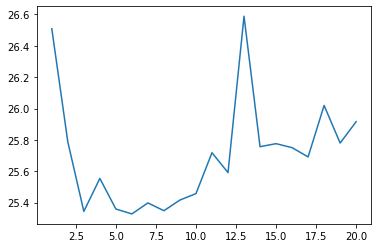

In [56]:
import matplotlib.pyplot as plt
x = np.arange(1,EPOCHS+1)
plt.plot(x, losses)
plt.show()

In [54]:
def test_model(model, loss_fn, test_generator):
    """
    Evaluate the performance of a model on the development set, providing the loss and macro F1 score.
    :param model: a model that performs 4-way emotion classification
    :param loss_fn: a function that can calculate loss between the predicted and gold labels
    :param test_generator: a DataLoader that provides batches of the testing set
    """
    gold = []
    predicted = []

    # Keep track of the loss
    loss = torch.zeros(1)  # requires_grad = False by default; float32 by default
    if USE_CUDA:
        loss = loss.cuda()

    model.eval()

    # Iterate over batches in the test dataset
    with torch.no_grad():
        for X_b, y_b in test_generator:
            # Predict
            y_pred = model(X_b)

            # Save gold and predicted labels for F1 score - take the argmax to convert to class labels
            gold.extend(y_b.cpu().detach().numpy())
            predicted.extend(y_pred.argmax(1).cpu().detach().numpy())

            loss += loss_fn(y_pred.double(), y_b.long()).data

    # Print total loss and macro F1 score
    print("Test loss: ")
    print(loss)
    print("F-score: ")
    print(f1_score(gold, predicted, average='macro'))

test_model(model3, criterion, test_generator)

Test loss: 
tensor([26.1769])
F-score: 
0.45341626079984587
